# Web Scraping peleadores y estadisticas

## Import libraries

In [3]:
!pip install streamlit

     |████████████████████████████████| 9.1 MB 184 kB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 518 kB/s eta 0:00:01
     |████████████████████████████████| 235 kB 324 kB/s eta 0:00:01
  Using cached Pympler-1.0.1-py3-none-any.whl (164 kB)
  Using cached tzlocal-4.2-py3-none-any.whl (19 kB)
  Using cached validators-0.20.0.tar.gz (30 kB)
     |████████████████████████████████| 35.3 MB 101 kB/s eta 0:00:01     |█████████▋                      | 10.6 MB 549 kB/s eta 0:00:45     |███████████████▍                | 17.0 MB 476 kB/s eta 0:00:39     |█████████████████████           | 23.1 MB 351 kB/s eta 0:00:35
  Using cached altair-4.2.0-py3-none-any.whl (812 kB)
  Using cached GitPython-3.1.27-py3-none-any.whl (181 kB)
  Using cached semver-2.13.0-py2.py3-none-any.whl (12 kB)
  Using cached gitdb-4.0.9-py3-none-any.whl (63 kB)
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
  Using cached commonmark-0.9.1-py2.py3-none-any.whl (51 kB)
     |███████████████████████████

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup as BS
import requests
import json
import time
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
import streamlit as st
from functools import reduce

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### pruebas

In [ ]:
df = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Eventos_de_UFC')

In [ ]:
eventos = df[0].copy()

In [ ]:
eventos.shape

(599, 6)

In [ ]:
eventos.tail(20)

,#,Evento,Fecha,Sede,Localización,Fuente
579,571,UFC on ESPN: Sandhagen vs. Dillashaw,24 de julio de 2021,UFC Apex,"Las Vegas, Nevada",NaN
580,572,UFC on ESPN: Hall vs. Strickland,31 de julio de 2021,UFC Apex,"Las Vegas, Nevada",NaN
581,573,UFC 265: Lewis vs. Gane,7 de agosto de 2021,Toyota Center,"Houston, Texas",NaN
582,574,UFC on ESPN: Cannonier vs. Gastelum,21 de agosto de 2021,UFC Apex,"Las Vegas, Nevada",NaN
583,575,UFC on ESPN: Barboza vs. Chikadze,28 de agosto de 2021,UFC Apex,"Las Vegas, Nevada",NaN
584,576,UFC Fight Night: Brunson vs. Till,4 de septiembre de 2021,UFC Apex,"Las Vegas, Nevada",NaN
585,577,UFC Fight Night: Smith vs. Spann,18 de septiembre de 2021,UFC Apex,"Las Vegas, Nevada",NaN
586,578,UFC 266: Volkanovski vs. Ortega,25 de septiembre de 2021,T-Mobile Arena,"Paradise, Nevada",NaN
587,579,UFC Fight Night: Santos vs. Walker,2 de octubre de 2021,UFC Apex,"Las Vegas, Nevada",NaN
588,580,UFC Fight Night: Dern vs. Rodriguez,9 de octubre de 2021,UFC Apex,"Las Vegas, Nevada",NaN


In [ ]:
eventos.tail()

,#,Evento,Fecha,Sede,Localización,Fuente
594,586,UFC Fight Night: Vieira vs. Tate,20 de noviembre de 2021,UFC Apex,"Las Vegas, Nevada",NaN
595,587,UFC on ESPN: Font vs. Aldo,4 de diciembre de 2021,UFC Apex,"Las Vegas, Nevada",NaN
596,588,UFC 269: Oliveira vs. Poirier,11 de diciembre de 2021,T-Mobile Arena,"Las Vegas, Nevada",NaN
597,589,UFC Fight Night: Lewis vs. Daukaus,18 de diciembre de 2021,UFC Apex,"Las Vegas, Nevada",NaN
598,590,UFC on ESPN: Kattar vs. Chikadze,15 de enero de 2022,UFC Apex,"Las Vegas, Nevada",NaN


In [ ]:
wiki_baselink = 'https://es.wikipedia.org'
response = requests.get('https://es.wikipedia.org/wiki/Anexo:Eventos_de_UFC')
soup = BS(response.text)
scrap_table = soup.find('tbody')
rows = scrap_table.find_all('tr')[1:]
wikilink_event = []
for row in rows:
    event_link = row.find_all('a')[0]['href']
    complete_link = wiki_baselink + event_link
    wikilink_event.append(complete_link)

In [ ]:
eventos['link_wiki'] = pd.Series(wikilink_event)

In [ ]:
eventos['Fuente'] = eventos['Fuente'].fillna('-')
NO_eventos = eventos[eventos['Fuente'].str.contains('Cancelado')].index
eventos.drop(NO_eventos, inplace = True)
eventos.shape

(590, 7)

In [ ]:
eventos.drop(['#', 'Fuente'], axis = 1, inplace = True)
eventos.reset_index(drop=True, inplace = True)

In [ ]:
eventos.tail()

,Evento,Fecha,Sede,Localización,link_wiki
585,UFC Fight Night: Vieira vs. Tate,20 de noviembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_Fight_Night:...
586,UFC on ESPN: Font vs. Aldo,4 de diciembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_on_ESPN:_Fon...
587,UFC 269: Oliveira vs. Poirier,11 de diciembre de 2021,T-Mobile Arena,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_269
588,UFC Fight Night: Lewis vs. Daukaus,18 de diciembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_Fight_Night:...
589,UFC on ESPN: Kattar vs. Chikadze,15 de enero de 2022,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_on_ESPN:_Kat...


In [ ]:
eventos.shape

(590, 5)

## Recaudacion eventos scraping

In [ ]:
ingresos = []
for link in eventos['link_wiki']:
    response = requests.get(link)
    soup = BS(response.text)
    scrap_table = soup.find('tbody')
    rows = scrap_table.find_all('tr')
    elementos = [row.text.split('\n') for row in rows]
    for elemento in elementos:
        if 'Recaudación' in elemento:
            ingresos.append(unicodedata.normalize("NFKD", elemento[1]))
            break
        if elemento == elementos[-1]:
            ingresos.append('Not Found')
            
len(ingresos) 

590

In [ ]:
eventos['ingresos_totales'] = pd.Series(ingresos)
eventos.tail()

,Evento,Fecha,Sede,Localización,link_wiki,ingresos_totales
585,UFC Fight Night: Vieira vs. Tate,20 de noviembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_Fight_Night:...,Not Found
586,UFC on ESPN: Font vs. Aldo,4 de diciembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_on_ESPN:_Fon...,Not Found
587,UFC 269: Oliveira vs. Poirier,11 de diciembre de 2021,T-Mobile Arena,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_269,"$8,000,000[2]​"
588,UFC Fight Night: Lewis vs. Daukaus,18 de diciembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_Fight_Night:...,Not Found
589,UFC on ESPN: Kattar vs. Chikadze,15 de enero de 2022,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_on_ESPN:_Kat...,Not Found


### Formatear ingresos

In [ ]:
def format_ingresos(ingreso_str):
    try:
        formated_ingreso = ingreso_str.split('[')[0].replace('$', '').replace(',', '')
    except:
        formated_ingreso = ingreso_str
    return formated_ingreso

In [ ]:
eventos['ingresos_dollar'] = eventos['ingresos_totales'].apply(format_ingresos)
eventos.tail()

,Evento,Fecha,Sede,Localización,link_wiki,ingresos_totales,ingresos_dollar
585,UFC Fight Night: Vieira vs. Tate,20 de noviembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_Fight_Night:...,Not Found,Not Found
586,UFC on ESPN: Font vs. Aldo,4 de diciembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_on_ESPN:_Fon...,Not Found,Not Found
587,UFC 269: Oliveira vs. Poirier,11 de diciembre de 2021,T-Mobile Arena,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_269,"$8,000,000[2]​",8000000
588,UFC Fight Night: Lewis vs. Daukaus,18 de diciembre de 2021,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_Fight_Night:...,Not Found,Not Found
589,UFC on ESPN: Kattar vs. Chikadze,15 de enero de 2022,UFC Apex,"Las Vegas, Nevada",https://es.wikipedia.org/wiki/UFC_on_ESPN:_Kat...,Not Found,Not Found


In [ ]:
notfound_eventos = eventos[eventos['ingresos_totales'] == 'Not Found']
notfound_eventos


,Evento,Fecha,Sede,Localización,link_wiki,ingresos_totales,ingresos_dollar
14,UFC 13: The Ultimate Force,30 de mayo de 1997,Augusta Civic Center,"Augusta, Georgia, USA",https://es.wikipedia.org/wiki/UFC_13,Not Found,Not Found
15,UFC 14: Showdown,27 de julio de 1997,Boutwell Auditorium,"Birmingham, Alabama, USA",https://es.wikipedia.org/wiki/UFC_14,Not Found,Not Found
16,UFC 15: Collision Course,17 de octubre de 1997,Casino Magic Bay St. Louis,"Bay St. Louis, Mississippi, USA",https://es.wikipedia.org/wiki/UFC_15,Not Found,Not Found
17,UFC Ultimate Japan,21 de diciembre de 1997,Yokohama Arena,"Yokohama, Japón",https://es.wikipedia.org/wiki/UFC_Japan,Not Found,Not Found
18,UFC 16: Battle in the Bayou,13 de marzo de 1998,Pontchartrain Center,"Nueva Orleans, Lousiana, USA",https://es.wikipedia.org/wiki/UFC_16,Not Found,Not Found
19,UFC 17: Redemption,15 de mayo de 1998,Mobile Civic Center,"Mobile, Alabama, USA",https://es.wikipedia.org/wiki/UFC_17,Not Found,Not Found
20,UFC Ultimate Brazil,16 de octubre de 1998,Ginásio da Portuguesa,"São Paulo, Brasil",https://es.wikipedia.org/wiki/UFC_Brazil,Not Found,Not Found
21,UFC 18: The Road to the Heavyweight Title,8 de enero de 1999,Pontchartrain Center,"Nueva Orleans, Lousiana, USA",https://es.wikipedia.org/wiki/UFC_18,Not Found,Not Found
22,UFC 19: Ultimate Young Guns,5 de marzo de 1999,Casino Magic Bay St. Louis,"Bay St. Louis, Mississippi, USA",https://es.wikipedia.org/wiki/UFC_19,Not Found,Not Found
23,UFC 20: Battle for the Gold,7 de mayo de 1999,Boutwell Auditorium,"Birmingham, Alabama, USA",https://es.wikipedia.org/wiki/UFC_20,Not Found,Not Found


### Scraping Fighters


In [ ]:
abecedario = string.ascii_lowercase
fighters_df_list = []
for letra in abecedario:
    fighter_letra_link = f'http://ufcstats.com/statistics/fighters?char={letra}&page=all'
    df_fighters = pd.read_html(fighter_letra_link)[0]
    df_fighters.dropna(how = 'all', axis = 0, inplace = True)
    df_fighters.reset_index(drop=True, inplace = True)

    response = requests.get(fighter_letra_link)
    soup = BS(response.text)
    enlaces = []
    for tr in soup.find_all('tr')[2:]:
        enlace = tr.find('a')['href']
        enlaces.append(enlace)
    df_fighters['enlaces'] = pd.Series(enlaces)

    fighters_df_list.append(df_fighters)
    

In [ ]:
peleadores = pd.concat(fighters_df_list)
peleadores.shape

(3876, 12)

In [ ]:
peleadores.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/93fe7332d1...
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN,http://ufcstats.com/fighter-details/15df64c02b...
2,Nariman,Abbasov,NaN,"5' 8""",155 lbs.,--,NaN,27.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/59a9d6dac6...
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN,http://ufcstats.com/fighter-details/b361180739...
4,Hamdy,Abdelwahab,The Hammer,"6' 2""",264 lbs.,"72.0""",Southpaw,6.0,0.0,0.0,NaN,http://ufcstats.com/fighter-details/3329d692ae...


In [ ]:
stats = []
for link in peleadores['enlaces']:
    response = requests.get(link)
    soup = BS(response.text)
    stats_peleador = {}
    for li in soup.find_all('li')[3:17]:
        lista = li.text.replace('\n', ' ').strip().split(':')
        lista = [elemento.strip() for elemento in lista]
        if len(lista[0]) != 0:
            stats_peleador[lista[0]] = lista[1]
            
    stats.append(stats_peleador)        
df_stats = pd.DataFrame(stats)

In [ ]:
df_stats.tail()

,Height,Weight,Reach,STANCE,DOB,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.
3871,--,170 lbs.,--,,"Mar 05, 1980",0.00,0%,0.00,0%,0.00,0%,0%,0.0
3872,--,145 lbs.,--,,--,0.00,0%,0.00,0%,0.00,0%,0%,0.0
3873,"5' 9""",185 lbs.,--,,--,7.64,38%,5.45,37%,0.00,0%,100%,0.0
3874,"5' 7""",155 lbs.,"70""",Orthodox,"Apr 04, 1992",3.93,52%,1.80,61%,0.00,0%,57%,1.0
3875,"6' 2""",205 lbs.,"74""",,"Jun 26, 1982",3.34,48%,4.87,39%,1.31,30%,50%,0.0


In [ ]:
df_stats.shape

(3876, 13)

In [ ]:
peleadores.tail(100)

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces
107,Karolina,Wojcik,Polish Assassin,"5' 2""",115 lbs.,--,Orthodox,9.0,2.0,0.0,NaN,http://ufcstats.com/fighter-details/b99b362083...
108,Danyelle,Wolf,NaN,"5' 11""",145 lbs.,"70.0""",Orthodox,1.0,0.0,0.0,NaN,http://ufcstats.com/fighter-details/a7e3f02fe2...
109,Brandon,Wolff,NaN,"5' 9""",170 lbs.,--,Orthodox,7.0,5.0,0.0,NaN,http://ufcstats.com/fighter-details/aa79d53995...
110,Xue Do,Won,NaN,"5' 7""",165 lbs.,--,NaN,0.0,1.0,0.0,NaN,http://ufcstats.com/fighter-details/daa89f01e1...
111,Joanne,Wood,JoJo,"5' 6""",125 lbs.,"65.0""",Orthodox,15.0,8.0,0.0,NaN,http://ufcstats.com/fighter-details/12f91bfa8f...
112,Nathaniel,Wood,The Prospect,"5' 6""",145 lbs.,"69.0""",Orthodox,18.0,5.0,0.0,NaN,http://ufcstats.com/fighter-details/329e403448...
113,Tyron,Woodley,The Chosen One,"5' 9""",170 lbs.,"74.0""",Orthodox,19.0,7.0,1.0,NaN,http://ufcstats.com/fighter-details/effd9de993...
114,Salvador,Woods,NaN,"5' 11""",170 lbs.,--,NaN,8.0,17.0,0.0,NaN,http://ufcstats.com/fighter-details/8de471543d...
115,Sean,Woodson,The Sniper,"6' 2""",145 lbs.,"78.0""",Orthodox,9.0,1.0,0.0,NaN,http://ufcstats.com/fighter-details/4682bc59d5...
116,Cal,Worsham,NaN,"5' 11""",230 lbs.,--,Orthodox,13.0,10.0,0.0,NaN,http://ufcstats.com/fighter-details/de3ed2e152...


In [ ]:
peleadores.reset_index(drop=True, inplace=True)

In [ ]:
peleadores.tail()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces
3871,Dave,Zitanick,NaN,--,170 lbs.,--,NaN,5.0,7.0,0.0,NaN,http://ufcstats.com/fighter-details/be124bdd60...
3872,Alex,Zuniga,NaN,--,145 lbs.,--,NaN,6.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/02d808afb9...
3873,George,Zuniga,NaN,"5' 9""",185 lbs.,--,NaN,3.0,1.0,0.0,NaN,http://ufcstats.com/fighter-details/1291dd6b8a...
3874,Allan,Zuniga,Tigre,"5' 7""",155 lbs.,"70.0""",Orthodox,13.0,1.0,0.0,NaN,http://ufcstats.com/fighter-details/523af801b3...
3875,Virgil,Zwicker,RezDog,"6' 2""",205 lbs.,"74.0""",NaN,15.0,6.0,1.0,NaN,http://ufcstats.com/fighter-details/0c277f3ff6...


In [ ]:
fighter_stats_df = pd.concat([peleadores, df_stats], axis = 1)

In [ ]:
fighter_stats_df.to_csv('fighter_stats.csv', index=False)
#eventos.to_csv('eventos_UFC.csv', index=False)

### Scraping bouts


In [43]:
bouts_link = 'http://ufcstats.com/statistics/events/completed?page=all'
events_v2 = pd.read_html(bouts_link)[0]
events_v2.head()

,Name/date,Location
0,NaN,NaN
1,"UFC 281: Adesanya vs. Pereira November 12, 2022","New York City, New York, USA"
2,UFC Fight Night: Rodriguez vs. Lemos November...,"Las Vegas, Nevada, USA"
3,"UFC Fight Night: Kattar vs. Allen October 29,...","Las Vegas, Nevada, USA"
4,"UFC 280: Oliveira vs. Makhachev October 22, 2022","Abu Dhabi, Abu Dhabi, United Arab Emirates"


In [44]:
events_v2.drop([0,1], inplace=True)
events_v2.reset_index(drop=True, inplace=True)

In [45]:
events_v2.shape

(625, 2)

In [46]:
events_v2.head()

,Name/date,Location
0,UFC Fight Night: Rodriguez vs. Lemos November...,"Las Vegas, Nevada, USA"
1,"UFC Fight Night: Kattar vs. Allen October 29,...","Las Vegas, Nevada, USA"
2,"UFC 280: Oliveira vs. Makhachev October 22, 2022","Abu Dhabi, Abu Dhabi, United Arab Emirates"
3,UFC Fight Night: Grasso vs. Araujo October 15...,"Las Vegas, Nevada, USA"
4,"UFC Fight Night: Dern vs. Yan October 01, 2022","Las Vegas, Nevada, USA"


In [47]:
response = requests.get(bouts_link)
soup = BS(response.text)
scrap_table = soup.find('tbody')
rows = scrap_table.find_all('a')
event_link = []
for row in rows[1:]:
    event = row['href']
    event_link.append(event)

In [48]:
events_v2['link']= pd.Series(event_link)

In [49]:
events_v2.tail()

,Name/date,Location,link
620,"UFC 6: Clash of the Titans July 14, 1995","Casper, Wyoming, USA",http://ufcstats.com/event-details/1c3f5e85b59e...
621,"UFC 5: The Return of the Beast April 07, 1995","Charlotte, North Carolina, USA",http://ufcstats.com/event-details/dedc3bb440d0...
622,"UFC 4: Revenge of the Warriors December 16, 1994","Tulsa, Oklahoma, USA",http://ufcstats.com/event-details/b60391da771d...
623,"UFC 3: The American Dream September 09, 1994","Charlotte, North Carolina, USA",http://ufcstats.com/event-details/1a49e0670dfa...
624,"UFC 2: No Way Out March 11, 1994","Denver, Colorado, USA",http://ufcstats.com/event-details/a6a9ab5a824e...


In [50]:
peleas_por_evento = []
for i in range(events_v2.shape[0]):
    response = requests.get(events_v2['link'][i])
    soup = BS(response.text)
    links_peleas = pd.Series([tr['data-link'] for tr in soup.find_all('tr')[1:]], name = 'link')
    fights = pd.read_html(events_v2['link'][i])[0]
    fecha = pd.Series(np.full(len(links_peleas), events_v2['Name/date'][i]), name = 'date_fight')
    fights_with_link = pd.concat([fights,fecha, links_peleas], axis = 1)
    peleas_por_evento.append(fights_with_link)
bouts = pd.concat(peleas_por_evento, axis=0)


In [51]:
bouts.head()

,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,date_fight,link
0,win,Amanda Lemos Marina Rodriguez,0 0,29 19,1 0,1 0,Women's Strawweight,KO/TKO Punches,3.0,0:54,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/abfc03893551...
1,win,Neil Magny Daniel Rodriguez,0 0,57 66,5 0,1 0,Welterweight,SUB D'Arce Choke,3.0,3:33,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/b279559f15ec...
2,win,Shayilan Nuerdanbieke Darrick Minner,1 0,19 5,0 0,0 0,Featherweight,KO/TKO Elbows,1.0,1:07,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/2664805fde34...
3,win,Tagir Ulanbekov Nate Maness,0 0,4 4,1 0,1 0,Flyweight,SUB Guillotine Choke,1.0,2:11,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/3adecfc4727a...
4,win,Grant Dawson Mark Madsen,1 0,33 15,2 0,2 0,Lightweight,SUB Rear Naked Choke,3.0,2:05,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/1535fb6549fa...


In [52]:
bouts.reset_index(drop=True, inplace=True)

In [53]:
bouts.tail()

,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,date_fight,link
6868,win,Orlando Wiet Robert Lucarelli,0 0,8 2,0 1,0 1,Open Weight,KO/TKO,1.0,2:50,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/3b020d4914b4...
6869,win,Frank Hamaker Thaddeus Luster,0 0,2 0,1 0,3 0,Open Weight,SUB Keylock,1.0,4:52,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/d917c8c7461b...
6870,win,Johnny Rhodes David Levicki,0 0,11 4,1 0,0 0,Open Weight,KO/TKO Punches,1.0,12:13,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/ccee020be2e8...
6871,win,Patrick Smith Ray Wizard,0 0,1 1,0 0,1 0,Open Weight,SUB Guillotine Choke,1.0,0:58,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/4b9ae533ccb3...
6872,win,Scott Morris Sean Daugherty,0 0,1 0,1 0,1 0,Open Weight,SUB Guillotine Choke,1.0,0:20,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/4acab67848e7...


In [54]:
bouts.to_csv('bouts_UFC.csv', index=False)

In [59]:
bouts.tail()

,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,date_fight,link
6868,win,Orlando Wiet Robert Lucarelli,0 0,8 2,0 1,0 1,Open Weight,KO/TKO,1.0,2:50,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/3b020d4914b4...
6869,win,Frank Hamaker Thaddeus Luster,0 0,2 0,1 0,3 0,Open Weight,SUB Keylock,1.0,4:52,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/d917c8c7461b...
6870,win,Johnny Rhodes David Levicki,0 0,11 4,1 0,0 0,Open Weight,KO/TKO Punches,1.0,12:13,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/ccee020be2e8...
6871,win,Patrick Smith Ray Wizard,0 0,1 1,0 0,1 0,Open Weight,SUB Guillotine Choke,1.0,0:58,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/4b9ae533ccb3...
6872,win,Scott Morris Sean Daugherty,0 0,1 0,1 0,1 0,Open Weight,SUB Guillotine Choke,1.0,0:20,"UFC 2: No Way Out March 11, 1994",http://ufcstats.com/fight-details/4acab67848e7...


## Dividir celdas peleadores

In [56]:
cols_dividir = ['Fighter', 'Kd', 'Str', 'Td', 'Sub']

In [64]:
def winner(fighters):
    separed = str(fighters).split('  ')
    winner = separed[0]
    return winner

In [65]:
bouts_chunks = pd.read_csv('./bouts_UFC.csv', chunksize = 20)
bouts_dfs = []
for chunk in bouts_chunks:
    chunk.drop(['W/L'], axis = 1, inplace = True)
    chunk['winner'] = chunk['Fighter'].apply(winner)
    rand0 = np.random.choice([0,1])
    rand1 = 0 if rand0 == 1 else 1
    for col in cols_dividir:
        new = chunk[col].str.split('  ', expand = True)
        col0 = str(col)+ '_0'
        col1 = str(col)+ '_1'
        chunk[col0] = new[rand0].copy()
        chunk[col1] = new[rand1].copy()
        chunk.drop(col, axis = 1, inplace = True)
    bouts_dfs.append(chunk)

bouts = pd.concat(bouts_dfs, ignore_index = True)

In [66]:
bouts.head()

,Weight class,Method,Round,Time,date_fight,link,winner,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1
0,Women's Strawweight,KO/TKO Punches,3.0,0:54,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/abfc03893551...,Amanda Lemos,Amanda Lemos,Marina Rodriguez,0,0,29,19,1,0,1,0
1,Welterweight,SUB D'Arce Choke,3.0,3:33,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/b279559f15ec...,Neil Magny,Neil Magny,Daniel Rodriguez,0,0,57,66,5,0,1,0
2,Featherweight,KO/TKO Elbows,1.0,1:07,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/2664805fde34...,Shayilan Nuerdanbieke,Shayilan Nuerdanbieke,Darrick Minner,1,0,19,5,0,0,0,0
3,Flyweight,SUB Guillotine Choke,1.0,2:11,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/3adecfc4727a...,Tagir Ulanbekov,Tagir Ulanbekov,Nate Maness,0,0,4,4,1,0,1,0
4,Lightweight,SUB Rear Naked Choke,3.0,2:05,UFC Fight Night: Rodriguez vs. Lemos November...,http://ufcstats.com/fight-details/1535fb6549fa...,Grant Dawson,Grant Dawson,Mark Madsen,1,0,33,15,2,0,2,0


In [67]:
bouts.to_csv('bouts_UFC.csv', index=False)

## Fighters csv

SLpM - Significant Strikes Landed per Minute

Str. Acc. - Significant Striking Accuracy

SApM - Significant Strikes Absorbed per Minute

Str. Def. - Significant Strike Defence (the % of opponents strikes that did not land)

TD Avg. - Average Takedowns Landed per 15 minutes

TD Acc. - Takedown Accuracy

TD Def. - Takedown Defense (the % of opponents TD attempts that did not land)

Sub. Avg. - Average Submissions Attempted per 15 minutes 

In [ ]:
fighters = pd.read_csv('fighter_stats.csv')

In [ ]:
fighters.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces,Height,Weight,Reach.1,STANCE,DOB,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/93fe7332d1...,--,155 lbs.,--,NaN,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN,http://ufcstats.com/fighter-details/15df64c02b...,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,Nariman,Abbasov,NaN,"5' 8""",155 lbs.,--,NaN,27.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/59a9d6dac6...,"5' 8""",155 lbs.,--,NaN,"Feb 01, 1994",0.00,0%,0.00,0%,0.00,0%,0%,0.0
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN,http://ufcstats.com/fighter-details/b361180739...,"6' 0""",265 lbs.,--,Switch,--,1.35,30%,3.55,38%,1.07,33%,66%,0.0
4,Hamdy,Abdelwahab,The Hammer,"6' 2""",264 lbs.,"72.0""",Southpaw,6.0,0.0,0.0,NaN,http://ufcstats.com/fighter-details/3329d692ae...,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993",3.87,52%,3.13,59%,3.00,75%,0%,0.0


In [ ]:
fighters["Full Name"] = fighters["First"] + " " + fighters["Last"]

In [ ]:
fighters.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces,Height,Weight,Reach.1,STANCE,DOB,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,Full Name
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/93fe7332d1...,--,155 lbs.,--,NaN,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0,Tom Aaron
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN,http://ufcstats.com/fighter-details/15df64c02b...,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0,Danny Abbadi
2,Nariman,Abbasov,NaN,"5' 8""",155 lbs.,--,NaN,27.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/59a9d6dac6...,"5' 8""",155 lbs.,--,NaN,"Feb 01, 1994",0.00,0%,0.00,0%,0.00,0%,0%,0.0,Nariman Abbasov
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN,http://ufcstats.com/fighter-details/b361180739...,"6' 0""",265 lbs.,--,Switch,--,1.35,30%,3.55,38%,1.07,33%,66%,0.0,David Abbott
4,Hamdy,Abdelwahab,The Hammer,"6' 2""",264 lbs.,"72.0""",Southpaw,6.0,0.0,0.0,NaN,http://ufcstats.com/fighter-details/3329d692ae...,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993",3.87,52%,3.13,59%,3.00,75%,0%,0.0,Hamdy Abdelwahab


In [ ]:
def pies_a_cm(distancia_pies):
    if len(distancia_pies)>3:
        digits = re.findall('[0-9]+', distancia_pies)
        pies, pulgadas = re.findall('[0-9]+', distancia_pies)
        cm = round(float(pies) * 30.48 + float(pulgadas) * 2.54)
    elif len(distancia_pies) == 3:
        pulgadas = re.findall('[0-9]+', distancia_pies)[0]
        cm = round(float(pulgadas) * 2.54)
    else:
        cm = np.nan
    return cm

In [ ]:
fighters['Reach'] = fighters['Reach.1'].apply(pies_a_cm)

In [ ]:
fighters.drop(['Reach.1', 'Ht.', 'Wt.', 'STANCE', 'Nickname'], axis = 1, inplace = True)

In [ ]:
fighters['Height'] = fighters['Height'].apply(pies_a_cm)

In [ ]:
fighters.head()

,Full Name,Height,Weight,Reach,DOB,Stance,W,L,D,Belt,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,enlaces
0,Tom Aaron,NaN,155.0,NaN,1978-07-13,NaN,5.0,3.0,0.0,NaN,0.00,0,0.00,0,0.00,0,0,0.0,http://ufcstats.com/fighter-details/93fe7332d1...
1,Danny Abbadi,180.0,155.0,NaN,1983-07-03,Orthodox,4.0,6.0,0.0,NaN,3.29,38,4.41,57,0.00,0,77,0.0,http://ufcstats.com/fighter-details/15df64c02b...
2,Nariman Abbasov,173.0,155.0,NaN,1994-02-01,NaN,27.0,3.0,0.0,NaN,0.00,0,0.00,0,0.00,0,0,0.0,http://ufcstats.com/fighter-details/59a9d6dac6...
3,David Abbott,183.0,265.0,NaN,NaN,Switch,10.0,15.0,0.0,NaN,1.35,30,3.55,38,1.07,33,66,0.0,http://ufcstats.com/fighter-details/b361180739...
4,Hamdy Abdelwahab,188.0,264.0,183.0,1993-01-22,Southpaw,6.0,0.0,0.0,NaN,3.87,52,3.13,59,3.00,75,0,0.0,http://ufcstats.com/fighter-details/3329d692ae...


In [ ]:
fighters['Weight'] = fighters['Weight'].str[:3]

In [ ]:
fighters = fighters[['Full Name','Height', 'Weight','Reach', 'DOB', 
         'Stance', 'W', 'L', 'D', 'Belt', 'SLpM',
         'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.',
         'TD Acc.', 'TD Def.', 'Sub. Avg.', 
         'enlaces']]

In [ ]:
def delete_percentage(serie):
    return serie.str[:-1]

In [ ]:
cols_per = ['Str. Acc.', 'Str. Def', 'TD Acc.', 'TD Def.']
fighters[cols_per] = fighters[cols_per].apply(delete_percentage)

In [ ]:
date_parse_v1 = lambda x: np.nan if x == '--' else datetime.strptime(x, '%b %d, %Y')

In [ ]:
fighters['DOB'] = fighters['DOB'].apply(date_parse_v1)

In [ ]:
fighters.head()

,Full Name,Height,Weight,Reach,DOB,Stance,W,L,D,Belt,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,enlaces
0,Tom Aaron,NaN,155.0,NaN,1978-07-13,NaN,5.0,3.0,0.0,NaN,0.00,0,0.00,0,0.00,0,0,0.0,http://ufcstats.com/fighter-details/93fe7332d1...
1,Danny Abbadi,180.0,155.0,NaN,1983-07-03,Orthodox,4.0,6.0,0.0,NaN,3.29,38,4.41,57,0.00,0,77,0.0,http://ufcstats.com/fighter-details/15df64c02b...
2,Nariman Abbasov,173.0,155.0,NaN,1994-02-01,NaN,27.0,3.0,0.0,NaN,0.00,0,0.00,0,0.00,0,0,0.0,http://ufcstats.com/fighter-details/59a9d6dac6...
3,David Abbott,183.0,265.0,NaN,NaN,Switch,10.0,15.0,0.0,NaN,1.35,30,3.55,38,1.07,33,66,0.0,http://ufcstats.com/fighter-details/b361180739...
4,Hamdy Abdelwahab,188.0,264.0,183.0,1993-01-22,Southpaw,6.0,0.0,0.0,NaN,3.87,52,3.13,59,3.00,75,0,0.0,http://ufcstats.com/fighter-details/3329d692ae...


In [ ]:
delete_guion = lambda x: np.nan if x == '--' else x

In [ ]:
fighters['Weight'] = fighters['Weight'].apply(delete_guion)

In [ ]:
fighters.to_csv('fighter_stats.csv', index = False)

In [ ]:
fighters = pd.read_csv('fighter_stats.csv')

In [ ]:
fighters.dtypes

Full Name     object
Height       float64
Weight       float64
Reach        float64
DOB           object
Stance        object
W            float64
L            float64
D            float64
Belt         float64
SLpM         float64
Str. Acc.      int64
SApM         float64
Str. Def       int64
TD Avg.      float64
TD Acc.        int64
TD Def.        int64
Sub. Avg.    float64
enlaces       object
dtype: object

## merge fights and bouts

In [112]:
bouts = pd.read_csv('./bouts_UFC.csv')

In [113]:
bouts['date_fight'] = bouts['date_fight'].str.replace(',', '').str.split(' ')


In [119]:
def date_list(list_):
    date = list_[-3]+' '+list_[-2]+' '+list_[-1]
    return date
    

In [120]:
bouts['date_fight']=bouts['date_fight'].apply(date_list)

In [121]:
bouts['date_fight'][0]

'November 05 2022'

In [128]:
bouts.to_csv('bouts_UFC.csv', index=False)
bouts.head()

,Weight class,Method,Round,Time,date_fight,link,winner,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1
0,Women's Strawweight,KO/TKO Punches,3.0,0:54,November 05 2022,http://ufcstats.com/fight-details/abfc03893551...,Amanda Lemos,Amanda Lemos,Marina Rodriguez,0,0,29,19,1,0,1,0
1,Welterweight,SUB D'Arce Choke,3.0,3:33,November 05 2022,http://ufcstats.com/fight-details/b279559f15ec...,Neil Magny,Neil Magny,Daniel Rodriguez,0,0,57,66,5,0,1,0
2,Featherweight,KO/TKO Elbows,1.0,1:07,November 05 2022,http://ufcstats.com/fight-details/2664805fde34...,Shayilan Nuerdanbieke,Shayilan Nuerdanbieke,Darrick Minner,1,0,19,5,0,0,0,0
3,Flyweight,SUB Guillotine Choke,1.0,2:11,November 05 2022,http://ufcstats.com/fight-details/3adecfc4727a...,Tagir Ulanbekov,Tagir Ulanbekov,Nate Maness,0,0,4,4,1,0,1,0
4,Lightweight,SUB Rear Naked Choke,3.0,2:05,November 05 2022,http://ufcstats.com/fight-details/1535fb6549fa...,Grant Dawson,Grant Dawson,Mark Madsen,1,0,33,15,2,0,2,0


In [123]:
bouts_min = bouts[['Fighter_0', 'Fighter_1', 'date_fight', 'winner']].copy()

In [124]:
bouts_min.head()

,Fighter_0,Fighter_1,date_fight,winner
0,Amanda Lemos,Marina Rodriguez,November 05 2022,Amanda Lemos
1,Neil Magny,Daniel Rodriguez,November 05 2022,Neil Magny
2,Shayilan Nuerdanbieke,Darrick Minner,November 05 2022,Shayilan Nuerdanbieke
3,Tagir Ulanbekov,Nate Maness,November 05 2022,Tagir Ulanbekov
4,Grant Dawson,Mark Madsen,November 05 2022,Grant Dawson


In [125]:
bouts_min['winner'] = np.where(bouts_min['Fighter_0'] == bouts_min['winner'], 0, 1)

In [126]:
bouts_min.head(30)

,Fighter_0,Fighter_1,date_fight,winner
0,Amanda Lemos,Marina Rodriguez,November 05 2022,0
1,Neil Magny,Daniel Rodriguez,November 05 2022,0
2,Shayilan Nuerdanbieke,Darrick Minner,November 05 2022,0
3,Tagir Ulanbekov,Nate Maness,November 05 2022,0
4,Grant Dawson,Mark Madsen,November 05 2022,0
5,Miranda Maverick,Shanna Young,November 05 2022,0
6,Mario Bautista,Benito Lopez,November 05 2022,0
7,Polyana Viana,Jinh Yu Frey,November 05 2022,0
8,Johnny Munoz,Liudvik Sholinian,November 05 2022,0
9,Jake Hadley,Carlos Candelario,November 05 2022,0


In [127]:
bouts_fighter_stats = bouts_min.merge(fighters, how = 'inner', left_on = 'Fighter_0', right_on = 'Full Name')

NameError: name 'fighters' is not defined

In [ ]:
bouts_fighter_stats = bouts_fighter_stats.merge(fighters, how = 'inner', left_on = 'Fighter_1', right_on = 'Full Name', suffixes = ['_0', '_1'])

In [ ]:
bouts_fighter_stats.to_csv('./dataset_v1.csv', index = False)

In [ ]:
dataset = pd.read_csv('dataset_v1.csv', parse_dates=True)

# Fighters images selenium

In [37]:
driver = webdriver.Firefox(executable_path='./driver/geckodriver')
driver.get('https://www.ufcespanol.com/search?=&tabOrder=.%2Findex.html%2Cathletes%2Cevents%2Cfaqs%2Clinks%2Chelp_articles%2Cvideos%2Cpromotions&referrerPageUrl=&query=&facetFilters=%7B%22gender%22%3A%5B%5D%2C%22c_weightClass%22%3A%5B%5D%2C%22c_homeCountry%22%3A%5B%5D%2C%22c_accolades%22%3A%5B%5D%7D&filters=%7B%7D&search-offset=0&verticalUrl=Athletes.html')
time.sleep(10)

stats = []
names = []

#cookies_agree_button = driver.find_element_by_id('onetrust-accept-btn-handler')
#cookies_agree_button.click()
#time.sleep(3)



elements_fighters = driver.find_element_by_class_name('HitchhikerProductProminentImage-imgWrapper')
elements_fighters


WebDriverException: Message: Failed to decode response from marionette


In [41]:
stats = []
names = []

link = 'https://www.ufcespanol.com/search?=&tabOrder=.%2Findex.html%2Cathletes%2Cevents%2Cfaqs%2Clinks%2Chelp_articles%2Cvideos%2Cpromotions&referrerPageUrl=&query=&facetFilters=%7B%22gender%22%3A%5B%5D%2C%22c_weightClass%22%3A%5B%5D%2C%22c_homeCountry%22%3A%5B%5D%2C%22c_accolades%22%3A%5B%5D%7D&filters=%7B%7D&search-offset=0&verticalUrl=Athletes.html'

driver = webdriver.Firefox(executable_path='./driver/geckodriver')
driver.get(link)
time.sleep(6)

soup = driver.page_source



In [43]:
soup.find_all('div')

AttributeError: 'str' object has no attribute 'find_all'

In [40]:
divs

[]

In [11]:
elements_fighters[0].get_attribute('src')

'https://dmxg5wxfqgb4u.cloudfront.net/styles/event_fight_card_upper_body_of_standing_athlete/s3/2022-06/1cec21c3-e5c7-4d63-ab11-8d1c371b8b89%252FANGAA_R.png?itok=TE2oCUuM'

In [44]:
link = 'https://www.ufcespanol.com/search?=&tabOrder=.%2Findex.html%2Cathletes%2Cevents%2Cfaqs%2Clinks%2Chelp_articles%2Cvideos%2Cpromotions&referrerPageUrl=&query=&facetFilters=%7B%22gender%22%3A%5B%5D%2C%22c_weightClass%22%3A%5B%5D%2C%22c_homeCountry%22%3A%5B%5D%2C%22c_accolades%22%3A%5B%5D%7D&filters=%7B%7D&search-offset=0&verticalUrl=Athletes.html'

driver = webdriver.Firefox(executable_path='./driver/geckodriver')
driver.get(link)
time.sleep(5)



In [45]:
len(elements_fighters), len(names_fighters)

(0, 0)

In [ ]:
pictures = []
names = []
for element in elements_fighters:
    try:
        pictures.append(element.get_attribute(name='src'))
    except: 
        pictures.append(np.nan)

True

## Final dataset

In [ ]:
dataset.head()

,Fighter_0,Fighter_1,date_fight,winner,Full Name_0,Height_0,Weight_0,Reach_0,DOB_0,Stance_0,W_0,L_0,D_0,Belt_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,enlaces_0,Full Name_1,Height_1,Weight_1,Reach_1,DOB_1,Stance_1,W_1,L_1,D_1,Belt_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,enlaces_1
0,Jamahal Hill,Thiago Santos,2022-01-06,0,Jamahal Hill,193.0,205.0,201.0,1991-05-19,Southpaw,11.0,1.0,0.0,NaN,6.46,52,3.51,45,0.00,0,65,0.0,http://ufcstats.com/fighter-details/5444c5a201...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...
1,Kevin Holland,Thiago Santos,2018-01-04,1,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...
2,Aleksandar Rakic,Thiago Santos,2021-01-06,0,Aleksandar Rakic,193.0,205.0,198.0,1992-02-06,Orthodox,14.0,3.0,0.0,NaN,4.01,50,2.30,53,0.82,25,90,0.2,http://ufcstats.com/fighter-details/333b9e5c72...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...
3,Johnny Walker,Thiago Santos,2021-01-02,1,Johnny Walker,198.0,205.0,208.0,1992-03-30,Orthodox,18.0,7.0,0.0,NaN,3.45,58,2.78,42,0.23,100,62,0.7,http://ufcstats.com/fighter-details/c21f26bbde...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...
4,Jan Blachowicz,Thiago Santos,2019-01-23,1,Jan Blachowicz,188.0,205.0,198.0,1983-02-24,Orthodox,29.0,9.0,0.0,NaN,3.55,49,2.77,54,1.08,53,66,0.3,http://ufcstats.com/fighter-details/99df7d0a2a...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...


In [ ]:
date_parse_v2 = lambda x: np.nan if x == '--' else datetime.strptime(x, '%d, %Y')

In [ ]:
dataset['date_fight'] = dataset['date_fight'].apply(date_parse_v2)

ValueError: time data '2022-01-06' does not match format '%d, %Y'

In [ ]:
dataset['date_fight'] = dataset['date_fight'].astype('datetime64[ns]')

In [ ]:
dataset['DOB_0'] = dataset['DOB_0'].astype('datetime64[ns]')

In [ ]:
dataset['DOB_1'] = dataset['DOB_1'].astype('datetime64[ns]')

In [ ]:
dataset.dtypes

Fighter_0              object
Fighter_1              object
date_fight             object
winner                  int64
Full Name_0            object
Height_0              float64
Weight_0              float64
Reach_0               float64
DOB_0          datetime64[ns]
Stance_0               object
W_0                   float64
L_0                   float64
D_0                   float64
Belt_0                float64
SLpM_0                float64
Str. Acc._0             int64
SApM_0                float64
Str. Def_0              int64
TD Avg._0             float64
TD Acc._0               int64
TD Def._0               int64
Sub. Avg._0           float64
enlaces_0              object
Full Name_1            object
Height_1              float64
Weight_1              float64
Reach_1               float64
DOB_1          datetime64[ns]
Stance_1               object
W_1                   float64
L_1                   float64
D_1                   float64
Belt_1                float64
SLpM_1    

In [ ]:
dataset['edad_pelea_0'] = dataset['date_fight'].dt.year - dataset['DOB_0'].dt.year

In [ ]:
dataset['edad_pelea_1'] = dataset['date_fight'].dt.year - dataset['DOB_1'].dt.year 

In [ ]:
dataset.to_csv('./dataset_v1.csv', index=False)

### dataset v2

In [16]:
dataset = pd.read_csv('dataset_v1.csv')

In [17]:
dataset.shape

(6760, 48)

In [18]:
dataset.columns

Index(['Fighter_0', 'Fighter_1', 'date_fight', 'winner', 'Full Name_0',
       'Height_0', 'Weight_0', 'Reach_0', 'DOB_0', 'Stance_0', 'W_0', 'L_0',
       'D_0', 'Belt_0', 'SLpM_0', 'Str. Acc._0', 'SApM_0', 'Str. Def_0',
       'TD Avg._0', 'TD Acc._0', 'TD Def._0', 'Sub. Avg._0', 'enlaces_0',
       'Full Name_1', 'Height_1', 'Weight_1', 'Reach_1', 'DOB_1', 'Stance_1',
       'W_1', 'L_1', 'D_1', 'Belt_1', 'SLpM_1', 'Str. Acc._1', 'SApM_1',
       'Str. Def_1', 'TD Avg._1', 'TD Acc._1', 'TD Def._1', 'Sub. Avg._1',
       'enlaces_1', 'edad_pelea_0', 'edad_pelea_1', 'name_x', 'ufc_bouts_0',
       'name_y', 'ufc_bouts_1'],
      dtype='object')

In [19]:
colums_delete = ['date_fight', 'Full Name_0', 'Full Name_1',
                 'DOB_0', 'DOB_1', 'Belt_0', 'Belt_1',
                 'enlaces_0', 'enlaces_1', 'Fighter_0',
                 'Fighter_1', 'name_x', 'name_y']

In [20]:
dataset.drop(colums_delete, axis = 1, inplace = True)

In [21]:
dataset.head()

,winner,Height_0,Weight_0,Reach_0,Stance_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,Height_1,Weight_1,Reach_1,Stance_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_pelea_0,edad_pelea_1,ufc_bouts_0,ufc_bouts_1
0,0,193.0,205.0,201.0,Southpaw,11.0,1.0,0.0,6.46,52,3.51,45,0.00,0,65,0.0,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,31.0,38.0,7.0,24.0
1,1,190.0,170.0,206.0,Orthodox,23.0,7.0,0.0,3.90,54,2.41,55,0.84,43,50,0.6,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,26.0,34.0,15.0,24.0
2,0,193.0,205.0,198.0,Orthodox,14.0,3.0,0.0,4.01,50,2.30,53,0.82,25,90,0.2,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0
3,1,198.0,205.0,208.0,Orthodox,18.0,7.0,0.0,3.45,58,2.78,42,0.23,100,62,0.7,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0
4,1,188.0,205.0,198.0,Orthodox,29.0,9.0,0.0,3.55,49,2.77,54,1.08,53,66,0.3,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,36.0,35.0,18.0,24.0


In [22]:
dataset.to_csv('./dataset_v2.csv', index = False)

## Missing values

In [23]:
df = pd.read_csv('./dataset_v2.csv')

In [24]:
df.head()

,winner,Height_0,Weight_0,Reach_0,Stance_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,Height_1,Weight_1,Reach_1,Stance_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_pelea_0,edad_pelea_1,ufc_bouts_0,ufc_bouts_1
0,0,193.0,205.0,201.0,Southpaw,11.0,1.0,0.0,6.46,52,3.51,45,0.00,0,65,0.0,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,31.0,38.0,7.0,24.0
1,1,190.0,170.0,206.0,Orthodox,23.0,7.0,0.0,3.90,54,2.41,55,0.84,43,50,0.6,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,26.0,34.0,15.0,24.0
2,0,193.0,205.0,198.0,Orthodox,14.0,3.0,0.0,4.01,50,2.30,53,0.82,25,90,0.2,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0
3,1,198.0,205.0,208.0,Orthodox,18.0,7.0,0.0,3.45,58,2.78,42,0.23,100,62,0.7,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0
4,1,188.0,205.0,198.0,Orthodox,29.0,9.0,0.0,3.55,49,2.77,54,1.08,53,66,0.3,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,36.0,35.0,18.0,24.0


In [25]:
df.describe()

,winner,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_pelea_0,edad_pelea_1,ufc_bouts_0,ufc_bouts_1
count,6760.000000,6748.000000,6751.000000,6120.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6743.000000,6744.000000,6062.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6760.000000,6635.000000,6613.000000,6760.000000,6760.000000
mean,0.512278,178.645525,169.666272,183.125980,18.148225,7.578402,0.264941,3.242876,43.110651,3.278654,53.395858,1.561817,37.497337,57.910207,0.645902,178.822186,169.710261,183.246948,18.132544,7.583136,0.252219,3.239787,42.973964,3.262891,53.475000,1.504741,37.198964,58.102367,0.633817,30.127355,30.088160,11.357396,11.258136
std,0.499886,8.731542,36.012173,10.566654,9.783993,4.534500,0.694758,1.371457,10.472851,1.333893,11.202257,1.303093,20.573440,22.853860,0.850719,8.763275,37.033190,10.631545,9.452893,4.647530,0.691393,1.383094,10.560245,1.377135,11.433746,1.290300,20.589735,22.825282,0.751336,4.113028,4.206979,7.816040,7.731844
min,0.000000,152.000000,115.000000,147.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,115.000000,147.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,18.000000,1.000000,1.000000
25%,0.000000,173.000000,145.000000,178.000000,12.000000,4.000000,0.000000,2.380000,39.000000,2.510000,50.000000,0.580000,26.000000,47.000000,0.100000,173.000000,145.000000,178.000000,12.000000,4.000000,0.000000,2.390000,39.000000,2.450000,50.000000,0.540000,26.000000,48.000000,0.100000,27.000000,27.000000,5.000000,5.000000
50%,1.000000,180.000000,170.000000,183.000000,17.000000,7.000000,0.000000,3.180000,44.000000,3.100000,55.000000,1.300000,38.000000,61.000000,0.400000,180.000000,170.000000,183.000000,17.000000,7.000000,0.000000,3.200000,44.000000,3.100000,55.000000,1.220000,38.000000,62.000000,0.400000,30.000000,30.000000,10.000000,9.000000
75%,1.000000,185.000000,185.000000,190.000000,23.000000,10.000000,0.000000,3.980000,49.000000,3.960000,60.000000,2.310000,50.000000,73.000000,0.900000,185.000000,185.000000,190.000000,23.000000,10.000000,0.000000,4.010000,49.000000,3.940000,60.000000,2.160000,50.000000,73.000000,0.900000,33.000000,33.000000,16.000000,16.000000
max,1.000000,211.000000,345.000000,213.000000,253.000000,53.000000,10.000000,9.310000,100.000000,17.860000,85.000000,11.110000,100.000000,100.000000,21.900000,211.000000,770.000000,213.000000,253.000000,53.000000,11.000000,12.070000,100.000000,22.500000,100.000000,13.950000,100.000000,100.000000,12.100000,48.000000,51.000000,40.000000,40.000000


# Eliminar NANs

In [26]:
chunks_df = pd.read_csv('dataset_v2.csv', chunksize = 500)

In [27]:
df_list = []
for chunk in chunks_df:
    chunk.dropna(inplace = True)
    df_list.append(chunk)

df = pd.concat(df_list, ignore_index = True)

In [28]:
df.describe()

,winner,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_pelea_0,edad_pelea_1,ufc_bouts_0,ufc_bouts_1
count,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.00000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000,5668.000000
mean,0.525582,178.339097,166.908433,183.075159,18.453952,7.541990,0.230593,3.455517,44.366972,3.37870,55.120854,1.604388,38.569337,60.929958,0.627611,178.497883,166.773994,183.170254,18.532639,7.514291,0.214538,3.465129,44.428017,3.347068,55.253529,1.570371,38.563867,61.395201,0.627541,30.321983,30.265879,12.137615,12.198130
std,0.499389,8.807254,34.581257,10.659247,8.412149,4.306892,0.604322,1.251780,7.523889,1.19303,7.166750,1.260875,18.660999,19.757481,0.690254,8.812989,34.645879,10.666733,8.245066,4.356527,0.557782,1.230212,7.347024,1.170020,7.241708,1.255592,18.336722,19.347084,0.674679,4.061104,4.137532,7.686034,7.582201
min,0.000000,152.000000,115.000000,147.000000,0.000000,0.000000,0.000000,0.180000,8.000000,0.37000,21.000000,0.000000,0.000000,0.000000,0.000000,152.000000,115.000000,147.000000,0.000000,0.000000,0.000000,0.180000,12.000000,0.370000,12.000000,0.000000,0.000000,0.000000,0.000000,20.000000,19.000000,1.000000,1.000000
25%,0.000000,173.000000,145.000000,178.000000,13.000000,4.000000,0.000000,2.590000,40.000000,2.59000,51.000000,0.650000,28.000000,50.000000,0.100000,173.000000,145.000000,178.000000,13.000000,4.000000,0.000000,2.620000,40.000000,2.570000,51.000000,0.630000,28.000000,52.000000,0.100000,27.000000,27.000000,6.000000,6.000000
50%,1.000000,178.000000,155.000000,183.000000,17.000000,7.000000,0.000000,3.330000,44.000000,3.19000,56.000000,1.350000,38.000000,63.000000,0.500000,178.000000,155.000000,183.000000,17.000000,7.000000,0.000000,3.350000,44.000000,3.180000,56.000000,1.320000,38.000000,63.000000,0.500000,30.000000,30.000000,11.000000,11.000000
75%,1.000000,185.000000,185.000000,190.000000,23.000000,10.000000,0.000000,4.150000,49.000000,3.99000,60.000000,2.320000,50.000000,74.000000,0.900000,185.000000,185.000000,190.000000,23.000000,10.000000,0.000000,4.150000,49.000000,3.970000,60.000000,2.220000,50.000000,75.000000,0.900000,33.000000,33.000000,17.000000,17.000000
max,1.000000,211.000000,265.000000,213.000000,91.000000,26.000000,8.000000,9.310000,80.000000,14.41000,85.000000,10.980000,100.000000,100.000000,7.400000,211.000000,265.000000,213.000000,91.000000,26.000000,8.000000,12.070000,79.000000,15.480000,85.000000,11.270000,100.000000,100.000000,7.400000,47.000000,48.000000,40.000000,40.000000


In [29]:
df.to_csv('./df_del_nan.csv', index = False)

### Variables categoricas

In [30]:
df = pd.read_csv('df_del_nan.csv')

In [31]:
df['Stance_0'].unique()

array(['Southpaw', 'Orthodox', 'Switch', 'Open Stance'], dtype=object)

In [32]:
dummies_stance = pd.get_dummies(df[['Stance_0', 'Stance_1']], prefix = ['St_0', 'St_1'])

In [33]:
df = pd.concat([df, dummies_stance], axis=1)

In [34]:
df.head()

,winner,Height_0,Weight_0,Reach_0,Stance_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,Height_1,Weight_1,Reach_1,Stance_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_pelea_0,edad_pelea_1,ufc_bouts_0,ufc_bouts_1,St_0_Open Stance,St_0_Orthodox,St_0_Southpaw,St_0_Switch,St_1_Open Stance,St_1_Orthodox,St_1_Southpaw,St_1_Switch
0,0,193.0,205.0,201.0,Southpaw,11.0,1.0,0.0,6.46,52,3.51,45,0.00,0,65,0.0,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,31.0,38.0,7.0,24.0,0,0,1,0,0,1,0,0
1,1,190.0,170.0,206.0,Orthodox,23.0,7.0,0.0,3.90,54,2.41,55,0.84,43,50,0.6,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,26.0,34.0,15.0,24.0,0,1,0,0,0,1,0,0
2,0,193.0,205.0,198.0,Orthodox,14.0,3.0,0.0,4.01,50,2.30,53,0.82,25,90,0.2,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0,0,1,0,0,0,1,0,0
3,1,198.0,205.0,208.0,Orthodox,18.0,7.0,0.0,3.45,58,2.78,42,0.23,100,62,0.7,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0,0,1,0,0,0,1,0,0
4,1,188.0,205.0,198.0,Orthodox,29.0,9.0,0.0,3.55,49,2.77,54,1.08,53,66,0.3,188.0,205.0,193.0,Orthodox,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,36.0,35.0,18.0,24.0,0,1,0,0,0,1,0,0


In [35]:
df.drop(['Stance_0', 'Stance_1'], axis = 1, inplace = True)

In [36]:
df.head()

,winner,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_pelea_0,edad_pelea_1,ufc_bouts_0,ufc_bouts_1,St_0_Open Stance,St_0_Orthodox,St_0_Southpaw,St_0_Switch,St_1_Open Stance,St_1_Orthodox,St_1_Southpaw,St_1_Switch
0,0,193.0,205.0,201.0,11.0,1.0,0.0,6.46,52,3.51,45,0.00,0,65,0.0,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,31.0,38.0,7.0,24.0,0,0,1,0,0,1,0,0
1,1,190.0,170.0,206.0,23.0,7.0,0.0,3.90,54,2.41,55,0.84,43,50,0.6,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,26.0,34.0,15.0,24.0,0,1,0,0,0,1,0,0
2,0,193.0,205.0,198.0,14.0,3.0,0.0,4.01,50,2.30,53,0.82,25,90,0.2,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0,0,1,0,0,0,1,0,0
3,1,198.0,205.0,208.0,18.0,7.0,0.0,3.45,58,2.78,42,0.23,100,62,0.7,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0,0,1,0,0,0,1,0,0
4,1,188.0,205.0,198.0,29.0,9.0,0.0,3.55,49,2.77,54,1.08,53,66,0.3,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,36.0,35.0,18.0,24.0,0,1,0,0,0,1,0,0


In [37]:
df.to_csv('./df_del_nan_v2.csv', index = False)

# Normalizacion datos para DNN

In [38]:
df = pd.read_csv('df_del_nan_v2.csv')

In [39]:
df.head()

,winner,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_pelea_0,edad_pelea_1,ufc_bouts_0,ufc_bouts_1,St_0_Open Stance,St_0_Orthodox,St_0_Southpaw,St_0_Switch,St_1_Open Stance,St_1_Orthodox,St_1_Southpaw,St_1_Switch
0,0,193.0,205.0,201.0,11.0,1.0,0.0,6.46,52,3.51,45,0.00,0,65,0.0,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,31.0,38.0,7.0,24.0,0,0,1,0,0,1,0,0
1,1,190.0,170.0,206.0,23.0,7.0,0.0,3.90,54,2.41,55,0.84,43,50,0.6,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,26.0,34.0,15.0,24.0,0,1,0,0,0,1,0,0
2,0,193.0,205.0,198.0,14.0,3.0,0.0,4.01,50,2.30,53,0.82,25,90,0.2,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0,0,1,0,0,0,1,0,0
3,1,198.0,205.0,208.0,18.0,7.0,0.0,3.45,58,2.78,42,0.23,100,62,0.7,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,29.0,37.0,8.0,24.0,0,1,0,0,0,1,0,0
4,1,188.0,205.0,198.0,29.0,9.0,0.0,3.55,49,2.77,54,1.08,53,66,0.3,188.0,205.0,193.0,22.0,11.0,0.0,3.72,48,2.57,53,0.88,33,65,0.1,36.0,35.0,18.0,24.0,0,1,0,0,0,1,0,0


In [40]:
columns = df.columns

In [41]:
columns

Index(['winner', 'Height_0', 'Weight_0', 'Reach_0', 'W_0', 'L_0', 'D_0',
       'SLpM_0', 'Str. Acc._0', 'SApM_0', 'Str. Def_0', 'TD Avg._0',
       'TD Acc._0', 'TD Def._0', 'Sub. Avg._0', 'Height_1', 'Weight_1',
       'Reach_1', 'W_1', 'L_1', 'D_1', 'SLpM_1', 'Str. Acc._1', 'SApM_1',
       'Str. Def_1', 'TD Avg._1', 'TD Acc._1', 'TD Def._1', 'Sub. Avg._1',
       'edad_pelea_0', 'edad_pelea_1', 'ufc_bouts_0', 'ufc_bouts_1',
       'St_0_Open Stance', 'St_0_Orthodox', 'St_0_Southpaw', 'St_0_Switch',
       'St_1_Open Stance', 'St_1_Orthodox', 'St_1_Southpaw', 'St_1_Switch'],
      dtype='object')

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [43]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 19)

df_train_x = df_train[columns[1:]]
df_test_x = df_train[columns[1:]]

df_train_y = df_train[columns[0]]
df_test_y = df_train[columns[0]]

In [44]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(df_train_x)
X_test_scaled = scaler.fit_transform(df_test_x)

## DNN

In [30]:
!pip install tensorflow

In [45]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow import convert_to_tensor

2022-10-20 11:57:31.666785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 11:57:31.666823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [46]:
X = convert_to_tensor(X_train_scaled)
Y = convert_to_tensor(df_train_y)

2022-10-20 11:57:37.227131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-20 11:57:37.227158: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-20 11:57:37.227178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kschool-vm): /proc/driver/nvidia/version does not exist
2022-10-20 11:57:37.229873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
X.shape

TensorShape([4534, 40])

In [48]:
Y.shape

TensorShape([4534])

In [49]:
Y_t = to_categorical(Y, num_classes = 2)

Y_t.shape

(4534, 2)

In [52]:
model = Sequential()

l1 = Dense(units = 30, input_shape=(40, ))
model.add(l1)

l2 = Dense(units = 30, activation='relu')
model.add(l2)

l2 = Dense(units = 30, activation='relu')
model.add(l2)

l2 = Dense(units = 30, activation='relu')
model.add(l2)

l2 = Dense(units = 30, activation='relu')
model.add(l2)

out = Dense(units = 2, activation='sigmoid')
model.add(out)

model.summary()


model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ["accuracy"])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                1230      
                                                                 
 dense_7 (Dense)             (None, 30)                930       
                                                                 
 dense_8 (Dense)             (None, 30)                930       
                                                                 
 dense_9 (Dense)             (None, 30)                930       
                                                                 
 dense_10 (Dense)            (None, 30)                930       
                                                                 
 dense_11 (Dense)            (None, 2)                 62        
                                                                 
Total params: 5,012
Trainable params: 5,012
Non-traina

In [53]:
hist = model.fit(x = X, y = Y_t, batch_size = 50, validation_split = 0.1, epochs = 40)

Epoch 1/40
82/82 [==============================] - 1s 4ms/step - loss: 0.6890 - accuracy: 0.5370 - val_loss: 0.6761 - val_accuracy: 0.6035
Epoch 2/40
82/82 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6110 - val_loss: 0.6106 - val_accuracy: 0.6828
Epoch 3/40
82/82 [==============================] - 0s 3ms/step - loss: 0.5997 - accuracy: 0.6809 - val_loss: 0.5964 - val_accuracy: 0.6872
Epoch 4/40
82/82 [==============================] - 0s 4ms/step - loss: 0.5873 - accuracy: 0.6985 - val_loss: 0.5601 - val_accuracy: 0.6982
Epoch 5/40
82/82 [==============================] - 0s 4ms/step - loss: 0.5794 - accuracy: 0.7010 - val_loss: 0.5561 - val_accuracy: 0.6916
Epoch 6/40
82/82 [==============================] - 0s 3ms/step - loss: 0.5787 - accuracy: 0.7086 - val_loss: 0.5500 - val_accuracy: 0.7159
Epoch 7/40
82/82 [==============================] - 0s 4ms/step - loss: 0.5667 - accuracy: 0.7120 - val_loss: 0.5577 - val_accuracy: 0.7115
Epoch 8/40
82/82 [==

In [54]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.show()

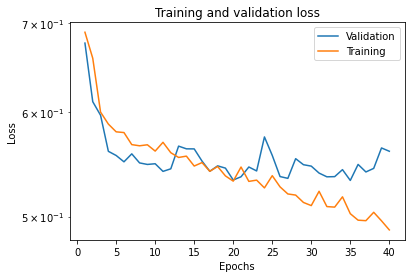

In [55]:
plot_metric(hist, 'loss')

# Streamlit

In [2]:
from PIL import Image 

In [13]:
%%writefile app.py

import streamlit as st
import pandas as pd
from PIL import Image 
  
st.set_page_config(page_title = 'Money Fighter', page_icon = ':large_yellow_square:') 


st.title('Money Fighter')
menu = ['Home', 'Stats', 'About']

choice = st.sidebar.selectbox('Menu', menu)
df = pd.read_csv('df_del_nan_v3.csv')

image = Image.open('./pak.jpg') 

if choice == 'Home':
    st.subheader('Home')
    st.table(df.head())
elif choice == 'Stats':
    st.subheader('Stats')
else:
    st.subheader('About')
    descripcion = ('Money Fighter  is a website that predicts the result of the upcoming MMA fights.\
         We take into account thousands of past bouts  and use a complex model to predict the \
         outcome of each fight.\
         Our predictions give you an edge over the bookmakers and other gamblers, \
         as well as insightful data about fighters’ tendencies in different situations. \
         Our predictions are 100% free and we do not accept any payments from the fighters, \
         their managers or promoters. Our goal is to help MMA fans understand the sport better\
         by providing them with valuable information about the upcoming fights.')
   
    st.image(image = image, width=200)
    st.markdown(f'<div style="text-align: justify;">{descripcion}</div>', unsafe_allow_html=True)                          

Overwriting app.py


# Mejoras dataset

In [2]:
bouts = pd.read_csv('./bouts_UFC.csv')
bouts.head()

,Weight class,Method,Round,Time,date_fight,link,winner,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1
0,Light Heavyweight,KO/TKO Elbows,4,2:31,"06, 2022",http://ufcstats.com/fight-details/a8bc6e005077...,Jamahal Hill,Jamahal Hill,Thiago Santos,0,0,89,53,0,6,0,0
1,Welterweight,KO/TKO Punches,3,2:01,"06, 2022",http://ufcstats.com/fight-details/a6b328733d61...,Geoff Neal,Geoff Neal,Vicente Luque,2,0,121,97,1,0,0,0
2,Heavyweight,KO/TKO Punch,2,0:36,"06, 2022",http://ufcstats.com/fight-details/36f38c2534ef...,Mohammed Usman,Mohammed Usman,Zac Pauga,1,0,12,32,0,0,0,0
3,Women's Flyweight,KO/TKO Elbows,3,3:57,"06, 2022",http://ufcstats.com/fight-details/2b11aa4b90b1...,Juliana Miller,Juliana Miller,Brogan Walker,0,0,54,30,4,0,1,0
4,Heavyweight,KO/TKO Punches,2,3:42,"06, 2022",http://ufcstats.com/fight-details/044d210d7b1e...,Serghei Spivac,Serghei Spivac,Augusto Sakai,0,0,33,8,6,0,1,0


In [3]:
num_ufc_bouts0 = pd.DataFrame(bouts.groupby('Fighter_0')['Fighter_0'].count())
num_ufc_bouts1 = pd.DataFrame(bouts.groupby('Fighter_1')['Fighter_1'].count())

num_ufc_bouts0.rename_axis('name', inplace = True)
num_ufc_bouts1.rename_axis('name', inplace = True)

num_ufc_bouts0.reset_index(inplace=True)
num_ufc_bouts1.reset_index(inplace=True)

num_ufc_bouts0.columns = ['name', '0total']
num_ufc_bouts1.columns = ['name', '1total']


In [4]:
num_ufc_bouts1.head()

,name,1total
0,AJ Dobson,1
1,Aalon Cruz,1
2,Aaron Brink,1
3,Aaron Phillips,2
4,Aaron Riley,3


In [5]:
bouts_total = num_ufc_bouts0.merge(num_ufc_bouts1, how = 'outer')
bouts_total.fillna(0, inplace = True)

In [6]:
bouts_total.head()

,name,0total,1total
0,AJ Fletcher,1.0,0.0
1,Aalon Cruz,1.0,1.0
2,Aaron Phillips,1.0,2.0
3,Aaron Riley,6.0,3.0
4,Aaron Simpson,7.0,4.0


In [7]:
bouts_total['ufc_bouts'] = bouts_total['0total'] + bouts_total['1total']

In [8]:
bouts_total = bouts_total[['name', 'ufc_bouts']]

In [9]:
df = pd.read_csv('./dataset_v1.csv')
df.head()

,Fighter_0,Fighter_1,date_fight,winner,Full Name_0,Height_0,Weight_0,Reach_0,DOB_0,Stance_0,W_0,L_0,D_0,Belt_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,enlaces_0,Full Name_1,Height_1,Weight_1,Reach_1,DOB_1,Stance_1,W_1,L_1,D_1,Belt_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,enlaces_1,edad_pelea_0,edad_pelea_1,name_x,ufc_bouts_0,name_y,ufc_bouts_1
0,Jamahal Hill,Thiago Santos,2022-01-06,0,Jamahal Hill,193.0,205.0,201.0,1991-05-19,Southpaw,11.0,1.0,0.0,NaN,6.46,52,3.51,45,0.00,0,65,0.0,http://ufcstats.com/fighter-details/5444c5a201...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,31.0,38.0,Jamahal Hill,7.0,Thiago Santos,24.0
1,Kevin Holland,Thiago Santos,2018-01-04,1,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,26.0,34.0,Kevin Holland,15.0,Thiago Santos,24.0
2,Aleksandar Rakic,Thiago Santos,2021-01-06,0,Aleksandar Rakic,193.0,205.0,198.0,1992-02-06,Orthodox,14.0,3.0,0.0,NaN,4.01,50,2.30,53,0.82,25,90,0.2,http://ufcstats.com/fighter-details/333b9e5c72...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,29.0,37.0,Aleksandar Rakic,8.0,Thiago Santos,24.0
3,Johnny Walker,Thiago Santos,2021-01-02,1,Johnny Walker,198.0,205.0,208.0,1992-03-30,Orthodox,18.0,7.0,0.0,NaN,3.45,58,2.78,42,0.23,100,62,0.7,http://ufcstats.com/fighter-details/c21f26bbde...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,29.0,37.0,Johnny Walker,8.0,Thiago Santos,24.0
4,Jan Blachowicz,Thiago Santos,2019-01-23,1,Jan Blachowicz,188.0,205.0,198.0,1983-02-24,Orthodox,29.0,9.0,0.0,NaN,3.55,49,2.77,54,1.08,53,66,0.3,http://ufcstats.com/fighter-details/99df7d0a2a...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,36.0,35.0,Jan Blachowicz,18.0,Thiago Santos,24.0


In [10]:
df = df.merge(bouts_total, how = 'inner', left_on = 'Fighter_0', right_on = 'name')

In [11]:
df = df.rename(columns = {'ufc_bouts':'ufc_bouts_0'})

In [12]:
df = df.merge(bouts_total, how = 'inner', left_on = 'Fighter_1', right_on = 'name')
df = df.rename(columns = {'ufc_bouts':'ufc_bouts_1'})

/home/dsc/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'name_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [13]:
df.head()

,Fighter_0,Fighter_1,date_fight,winner,Full Name_0,Height_0,Weight_0,Reach_0,DOB_0,Stance_0,W_0,L_0,D_0,Belt_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,enlaces_0,Full Name_1,Height_1,Weight_1,Reach_1,DOB_1,Stance_1,W_1,L_1,D_1,Belt_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,enlaces_1,edad_pelea_0,edad_pelea_1,name_x,ufc_bouts_0,name_y,ufc_bouts_1,name_x,ufc_bouts_0,name_y,ufc_bouts_1
0,Jamahal Hill,Thiago Santos,2022-01-06,0,Jamahal Hill,193.0,205.0,201.0,1991-05-19,Southpaw,11.0,1.0,0.0,NaN,6.46,52,3.51,45,0.00,0,65,0.0,http://ufcstats.com/fighter-details/5444c5a201...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,31.0,38.0,Jamahal Hill,7.0,Thiago Santos,24.0,Jamahal Hill,7.0,Thiago Santos,24.0
1,Kevin Holland,Thiago Santos,2018-01-04,1,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,26.0,34.0,Kevin Holland,15.0,Thiago Santos,24.0,Kevin Holland,15.0,Thiago Santos,24.0
2,Aleksandar Rakic,Thiago Santos,2021-01-06,0,Aleksandar Rakic,193.0,205.0,198.0,1992-02-06,Orthodox,14.0,3.0,0.0,NaN,4.01,50,2.30,53,0.82,25,90,0.2,http://ufcstats.com/fighter-details/333b9e5c72...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,29.0,37.0,Aleksandar Rakic,8.0,Thiago Santos,24.0,Aleksandar Rakic,8.0,Thiago Santos,24.0
3,Johnny Walker,Thiago Santos,2021-01-02,1,Johnny Walker,198.0,205.0,208.0,1992-03-30,Orthodox,18.0,7.0,0.0,NaN,3.45,58,2.78,42,0.23,100,62,0.7,http://ufcstats.com/fighter-details/c21f26bbde...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,29.0,37.0,Johnny Walker,8.0,Thiago Santos,24.0,Johnny Walker,8.0,Thiago Santos,24.0
4,Jan Blachowicz,Thiago Santos,2019-01-23,1,Jan Blachowicz,188.0,205.0,198.0,1983-02-24,Orthodox,29.0,9.0,0.0,NaN,3.55,49,2.77,54,1.08,53,66,0.3,http://ufcstats.com/fighter-details/99df7d0a2a...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,36.0,35.0,Jan Blachowicz,18.0,Thiago Santos,24.0,Jan Blachowicz,18.0,Thiago Santos,24.0


In [14]:
df.to_csv('./dataset_v1.csv', index = False)

In [15]:
df = pd.read_csv('./dataset_v1.csv')

In [16]:
df.head()

,Fighter_0,Fighter_1,date_fight,winner,Full Name_0,Height_0,Weight_0,Reach_0,DOB_0,Stance_0,W_0,L_0,D_0,Belt_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,enlaces_0,Full Name_1,Height_1,Weight_1,Reach_1,DOB_1,Stance_1,W_1,L_1,D_1,Belt_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,enlaces_1,edad_pelea_0,edad_pelea_1,name_x,ufc_bouts_0,name_y,ufc_bouts_1,name_x.1,ufc_bouts_0.1,name_y.1,ufc_bouts_1.1
0,Jamahal Hill,Thiago Santos,2022-01-06,0,Jamahal Hill,193.0,205.0,201.0,1991-05-19,Southpaw,11.0,1.0,0.0,NaN,6.46,52,3.51,45,0.00,0,65,0.0,http://ufcstats.com/fighter-details/5444c5a201...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,31.0,38.0,Jamahal Hill,7.0,Thiago Santos,24.0,Jamahal Hill,7.0,Thiago Santos,24.0
1,Kevin Holland,Thiago Santos,2018-01-04,1,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,26.0,34.0,Kevin Holland,15.0,Thiago Santos,24.0,Kevin Holland,15.0,Thiago Santos,24.0
2,Aleksandar Rakic,Thiago Santos,2021-01-06,0,Aleksandar Rakic,193.0,205.0,198.0,1992-02-06,Orthodox,14.0,3.0,0.0,NaN,4.01,50,2.30,53,0.82,25,90,0.2,http://ufcstats.com/fighter-details/333b9e5c72...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,29.0,37.0,Aleksandar Rakic,8.0,Thiago Santos,24.0,Aleksandar Rakic,8.0,Thiago Santos,24.0
3,Johnny Walker,Thiago Santos,2021-01-02,1,Johnny Walker,198.0,205.0,208.0,1992-03-30,Orthodox,18.0,7.0,0.0,NaN,3.45,58,2.78,42,0.23,100,62,0.7,http://ufcstats.com/fighter-details/c21f26bbde...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,29.0,37.0,Johnny Walker,8.0,Thiago Santos,24.0,Johnny Walker,8.0,Thiago Santos,24.0
4,Jan Blachowicz,Thiago Santos,2019-01-23,1,Jan Blachowicz,188.0,205.0,198.0,1983-02-24,Orthodox,29.0,9.0,0.0,NaN,3.55,49,2.77,54,1.08,53,66,0.3,http://ufcstats.com/fighter-details/99df7d0a2a...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,36.0,35.0,Jan Blachowicz,18.0,Thiago Santos,24.0,Jan Blachowicz,18.0,Thiago Santos,24.0


* Prueba actualizacion estadisticas segun fecha

In [17]:
mask = (df['Fighter_0'] == 'Kevin Holland') | (df['Fighter_1'] == 'Kevin Holland')
pruebadf = df[mask]

In [18]:
pruebadf.sort_values(by = 'date_fight')

,Fighter_0,Fighter_1,date_fight,winner,Full Name_0,Height_0,Weight_0,Reach_0,DOB_0,Stance_0,W_0,L_0,D_0,Belt_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,enlaces_0,Full Name_1,Height_1,Weight_1,Reach_1,DOB_1,Stance_1,W_1,L_1,D_1,Belt_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,enlaces_1,edad_pelea_0,edad_pelea_1,name_x,ufc_bouts_0,name_y,ufc_bouts_1,name_x.1,ufc_bouts_0.1,name_y.1,ufc_bouts_1.1
1,Kevin Holland,Thiago Santos,2018-01-04,1,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,Thiago Santos,188.0,205.0,193.0,1984-01-07,Orthodox,22.0,11.0,0.0,NaN,3.72,48,2.57,53,0.88,33,65,0.1,http://ufcstats.com/fighter-details/dea070ed4a...,26.0,34.0,Kevin Holland,15.0,Thiago Santos,24.0,Kevin Holland,15.0,Thiago Santos,24.0
981,John Phillips,Kevin Holland,2018-01-24,1,John Phillips,180.0,185.0,190.0,1985-06-09,Southpaw,22.0,11.0,0.0,NaN,1.72,34,4.03,49,0.00,0,7,0.0,http://ufcstats.com/fighter-details/e9ac7bfb65...,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,33.0,26.0,John Phillips,6.0,Kevin Holland,15.0,John Phillips,6.0,Kevin Holland,15.0
980,Brendan Allen,Kevin Holland,2019-01-18,0,Brendan Allen,188.0,185.0,190.0,1995-12-28,Orthodox,19.0,5.0,0.0,NaN,4.15,55,4.18,44,1.20,41,50,1.4,http://ufcstats.com/fighter-details/2f181c0467...,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,24.0,27.0,Brendan Allen,9.0,Kevin Holland,15.0,Brendan Allen,9.0,Kevin Holland,15.0
82,Kevin Holland,Alessio Di Chirico,2019-01-22,0,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,Alessio Di Chirico,183.0,185.0,188.0,1989-12-12,Orthodox,13.0,6.0,0.0,NaN,3.30,41,3.24,62,1.62,45,83,0.0,http://ufcstats.com/fighter-details/77d7295d1b...,27.0,30.0,Kevin Holland,15.0,Alessio Di Chirico,10.0,Kevin Holland,15.0,Alessio Di Chirico,10.0
979,Gerald Meerschaert,Kevin Holland,2019-01-30,1,Gerald Meerschaert,185.0,185.0,196.0,1987-12-18,Southpaw,34.0,15.0,0.0,NaN,3.04,44,3.53,51,2.25,40,29,1.8,http://ufcstats.com/fighter-details/6ac9bc2953...,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,32.0,27.0,Gerald Meerschaert,16.0,Kevin Holland,15.0,Gerald Meerschaert,16.0,Kevin Holland,15.0
977,Joaquin Buckley,Kevin Holland,2020-01-08,1,Joaquin Buckley,178.0,185.0,193.0,1994-04-27,Southpaw,15.0,4.0,0.0,NaN,3.74,34,3.42,54,1.68,35,64,0.0,http://ufcstats.com/fighter-details/b943760049...,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,26.0,28.0,Joaquin Buckley,7.0,Kevin Holland,15.0,Joaquin Buckley,7.0,Kevin Holland,15.0
976,Jacare Souza,Kevin Holland,2020-01-12,1,Jacare Souza,185.0,185.0,183.0,1979-12-07,Orthodox,26.0,10.0,0.0,NaN,2.53,47,2.83,62,2.57,39,57,1.3,http://ufcstats.com/fighter-details/7a703c565c...,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,41.0,28.0,Jacare Souza,16.0,Kevin Holland,15.0,Jacare Souza,16.0,Kevin Holland,15.0
982,Anthony Hernandez,Kevin Holland,2020-01-16,1,Anthony Hernandez,183.0,185.0,190.0,1993-10-18,Orthodox,9.0,2.0,0.0,NaN,4.26,58,3.93,46,5.39,70,66,2.3,http://ufcstats.com/fighter-details/093e1f5bb7...,Kevin Holland,190.0,170.0,206.0,1992-11-05,Orthodox,23.0,7.0,0.0,NaN,3.90,54,2.41,55,0.84,43,50,0.6,http://ufcstats.com/fighter-details/3a46b26801...,27.0,28.0,Anthony Hernandez,5.0,Kevin Holland,15.0,Anthony Hernandez,5.0,Kevin Holland,15.0
978,Darren Stewart,Kevin Hollan

In [108]:
bouts = pd.read_csv('./bouts_UFC.csv')
prueba2 = bouts.head().copy()

In [109]:
def min_sec(minutes):
    mins, secs = str(minutes).split(':')
    return int(mins)*60+int(secs)


def time_total_minutes(rounds, time):
    tot_time = (rounds-1)*300+time
    return tot_time/60


In [110]:
prueba2['Time'] = prueba2['Time'].apply(min_sec)

In [111]:
prueba2['total_time_min'] = prueba2.apply(lambda x: time_total_minutes(x['Round'], x['Time']), axis = 1)

In [112]:
prueba2.head()

,Weight class,Method,Round,Time,date_fight,link,winner,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1,total_time_min
0,Women's Strawweight,KO/TKO Punches,3.0,54,November 05 2022,http://ufcstats.com/fight-details/abfc03893551...,Amanda Lemos,Amanda Lemos,Marina Rodriguez,0,0,29,19,1,0,1,0,10.900000
1,Welterweight,SUB D'Arce Choke,3.0,213,November 05 2022,http://ufcstats.com/fight-details/b279559f15ec...,Neil Magny,Neil Magny,Daniel Rodriguez,0,0,57,66,5,0,1,0,13.550000
2,Featherweight,KO/TKO Elbows,1.0,67,November 05 2022,http://ufcstats.com/fight-details/2664805fde34...,Shayilan Nuerdanbieke,Shayilan Nuerdanbieke,Darrick Minner,1,0,19,5,0,0,0,0,1.116667
3,Flyweight,SUB Guillotine Choke,1.0,131,November 05 2022,http://ufcstats.com/fight-details/3adecfc4727a...,Tagir Ulanbekov,Tagir Ulanbekov,Nate Maness,0,0,4,4,1,0,1,0,2.183333
4,Lightweight,SUB Rear Naked Choke,3.0,125,November 05 2022,http://ufcstats.com/fight-details/1535fb6549fa...,Grant Dawson,Grant Dawson,Mark Madsen,1,0,33,15,2,0,2,0,12.083333


In [113]:
bouts['Time'].replace(np.nan, '0:0', inplace = True)

* Aplicar funcion de tiempo para tener el tiempo total de pelea en minutos

In [114]:
bouts['Time'] = bouts['Time'].apply(min_sec)
bouts['total_time_min'] = bouts.apply(lambda x: time_total_minutes(x['Round'], x['Time']), axis = 1)

In [115]:
bouts.head()

,Weight class,Method,Round,Time,date_fight,link,winner,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1,total_time_min
0,Women's Strawweight,KO/TKO Punches,3.0,54,November 05 2022,http://ufcstats.com/fight-details/abfc03893551...,Amanda Lemos,Amanda Lemos,Marina Rodriguez,0,0,29,19,1,0,1,0,10.900000
1,Welterweight,SUB D'Arce Choke,3.0,213,November 05 2022,http://ufcstats.com/fight-details/b279559f15ec...,Neil Magny,Neil Magny,Daniel Rodriguez,0,0,57,66,5,0,1,0,13.550000
2,Featherweight,KO/TKO Elbows,1.0,67,November 05 2022,http://ufcstats.com/fight-details/2664805fde34...,Shayilan Nuerdanbieke,Shayilan Nuerdanbieke,Darrick Minner,1,0,19,5,0,0,0,0,1.116667
3,Flyweight,SUB Guillotine Choke,1.0,131,November 05 2022,http://ufcstats.com/fight-details/3adecfc4727a...,Tagir Ulanbekov,Tagir Ulanbekov,Nate Maness,0,0,4,4,1,0,1,0,2.183333
4,Lightweight,SUB Rear Naked Choke,3.0,125,November 05 2022,http://ufcstats.com/fight-details/1535fb6549fa...,Grant Dawson,Grant Dawson,Mark Madsen,1,0,33,15,2,0,2,0,12.083333


In [116]:
def stat_per_min(mins, stat):
    if stat == 0 or mins == 0:
        return 0
    else:
        return round(stat/mins,2)

In [117]:
stats_cols = ['Kd_0', 'Kd_1', 'Str_0', 'Str_1', 'Td_0', 'Td_1', 'Sub_0', 'Sub_1']
for stats in stats_cols:
    prueba2[stats] = prueba2[stats].astype('int64')
    prueba2[f'{stats}_min'] = prueba2.apply(lambda x: stat_per_min(x[stats], x['total_time_min']), axis = 1)

In [121]:
bouts.dropna(how='any', inplace=True)

In [122]:
bouts.shape

(6868, 18)

In [123]:
bouts.describe()

,Round,Time,total_time_min
count,6868.000000,6868.000000,6868.000000
mean,2.329936,226.668754,10.427492
std,1.014269,99.041170,6.053034
min,1.000000,5.000000,0.083333
25%,1.000000,148.000000,4.533333
50%,3.000000,287.000000,12.950000
75%,3.000000,300.000000,15.000000
max,5.000000,1080.000000,25.000000


In [124]:
stats_cols = ['Kd_0', 'Kd_1', 'Str_0', 'Str_1', 'Td_0', 'Td_1', 'Sub_0', 'Sub_1']
for stats in stats_cols:
    bouts = bouts[bouts[stats] != '--']
    bouts[stats] = bouts[stats].astype('int64')
    bouts[f'{stats}_min'] = bouts.apply(lambda x: stat_per_min(x['total_time_min'], x[stats]), axis = 1)

In [125]:
bouts['date_fight'] = pd.to_datetime(bouts['date_fight'], format = '%B %d %Y')

In [126]:
bouts.to_csv('bouts_UFC_v2.csv', index=False)

In [127]:
bouts = pd.read_csv('./bouts_UFC_v2.csv', parse_dates=True)
sample = bouts.sample(100)

In [128]:
bouts['Method'].unique()

array(['KO/TKO  Punches', "SUB  D'Arce Choke", 'KO/TKO  Elbows',
       'SUB  Guillotine Choke', 'SUB  Rear Naked Choke', 'U-DEC',
       'SUB  Triangle Armbar', 'SUB  Triangle Choke',
       'KO/TKO  Flying Knee', 'KO/TKO', 'S-DEC', 'SUB  Anaconda Choke',
       'SUB  Arm Triangle', 'SUB  Armbar', 'M-DEC', 'KO/TKO  Kick',
       'KO/TKO  Punch', 'KO/TKO  Knee', 'SUB  Von Flue Choke',
       'SUB  Neck Crank', 'KO/TKO  Knees', 'KO/TKO  Spinning Back Elbow',
       'CNC', 'KO/TKO  Spinning Back Fist', 'KO/TKO  Elbow',
       'SUB  Keylock', 'SUB  Kneebar', 'DQ', 'SUB  Scarf Hold',
       'SUB  Straight Armbar', 'SUB  Inverted Triangle', 'SUB  Kimura',
       'Other', 'SUB  Heel Hook', 'Overturned', 'SUB  Ankle Lock',
       'KO/TKO  Slam', 'SUB  Forearm Choke', 'SUB  Injury',
       'KO/TKO  Spinning Back Kick', 'Overturned  Guillotine Choke',
       'Overturned  Punch', 'Overturned  Rear Naked Choke',
       'Overturned  Punches', 'Overturned  Knee', 'SUB  Twister',
       'Overturned 

In [131]:
bouts['Method'] = np.where(bouts['Method'].str.find('KO')>=0, 'KO', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('SUB')>=0, 'SUB', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('DEC')>=0, 'DEC', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('Choke')>=0, 'SUB', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('Punch')>=0, 'KO', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('Knee')>=0, 'KO', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('Triangle')>=0, 'SUB', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('Overturned')>=0, 'KO', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('Elbows')>=0, 'KO', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('Kick')>=0, 'KO', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('DQ')>=0, 'Other', bouts['Method'])
bouts['Method'] = np.where(bouts['Method'].str.find('CNC')>=0, 'Other', bouts['Method'])
bouts['Method'].unique()


array(['KO', 'SUB', 'DEC', 'Other'], dtype=object)

In [132]:
bouts.sample(5)

,Weight class,Method,Round,Time,date_fight,link,winner,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1,total_time_min,Kd_0_min,Kd_1_min,Str_0_min,Str_1_min,Td_0_min,Td_1_min,Sub_0_min,Sub_1_min
1628,Welterweight,DEC,3.0,300,2019-08-03,http://ufcstats.com/fight-details/f4bd11655ade...,Mickey Gall,Salim Touahri,Mickey Gall,0,0,48,50,0,1,0,0,15.000000,0.0,0.00,3.20,3.33,0.00,0.07,0.00,0.00
3678,Flyweight,SUB,5.0,299,2015-04-25,http://ufcstats.com/fight-details/6c2097664ac1...,Demetrious Johnson,Demetrious Johnson,Kyoji Horiguchi,0,0,66,31,14,1,1,0,24.983333,0.0,0.00,2.64,1.24,0.56,0.04,0.04,0.00
570,Light Heavyweight,DEC,5.0,300,2021-10-02,http://ufcstats.com/fight-details/37c484012ef2...,Thiago Santos,Johnny Walker,Thiago Santos,0,0,48,44,0,0,0,0,25.000000,0.0,0.00,1.92,1.76,0.00,0.00,0.00,0.00
3914,Bantamweight,KO,1.0,178,2014-11-07,http://ufcstats.com/fight-details/c3d336f9aabc...,Marcus Brimage,Jumabieke Tuerxun,Marcus Brimage,0,1,6,5,0,0,0,0,2.966667,0.0,0.34,2.02,1.69,0.00,0.00,0.00,0.00
6226,Lightweight,DEC,5.0,300,2006-10-14,http://ufcstats.com/fight-details/e30ee434b864...,Sean Sherk,Kenny Florian,Sean Sherk,0,0,23,60,0,8,4,1,25.000000,0.0,0.00,0.92,2.40,0.00,0.32,0.16,0.04


In [133]:
bouts.to_csv('bouts_UFC_v2.csv', index=False)

In [134]:
bouts = pd.read_csv('bouts_UFC_v2.csv')

In [148]:
def racha(col_peleador, col_ganador):
    col_rachas = [0]
    racha = 0
    for i in range(1,len(col_peleador)):
        if col_peleador[i-1] == col_ganador[i-1]:
            if col_rachas[i-1] > 0:
                racha += 1
                col_rachas.append(racha)
            else:
                racha = 1
                col_rachas.append(racha)
                
        if col_peleador[i-1] != col_ganador[i-1]:
            if col_rachas[i-1] < 0:
                racha -= 1
                col_rachas.append(racha)
            else:
                racha = -1
                col_rachas.append(racha)
    
    return col_rachas
        

In [149]:
list_peleadores = list(set(bouts['Fighter_0']) | set(bouts['Fighter_1']))
cols = bouts.columns
cols0 = [col for col in cols if col.find('0')>=1]
cols1 = [col for col in cols if col.find('1')>=1]
cols0.extend(['total_time_min', 'Weight class', 'Method', 'date_fight', 'winner'])
cols1.extend(['total_time_min', 'Weight class', 'Method', 'date_fight', 'winner'])
colsmerg = ['name', 'Kd', 'Str', 'Td', 'Sub', 'Kd_min', 'Str_min', 'Td_min', 'Sub_min', 
           'total_time_min', 'Weight class', 'Method', 'date_fight', 'winner']

for peleador in list_peleadores[:1]:
    
    ## Combinar peleas 'local' y 'visitante' para calculo estadisitcas por pelea
    df0 = bouts[bouts['Fighter_0']==peleador]
    df0 = df0[cols0]
    df0.columns = colsmerg
    df1 = bouts[bouts['Fighter_1']==peleador]
    df1 = df1[cols1]
    df1.columns = colsmerg
    df_peleador = pd.concat([df0, df1])
    df_peleador['date_fight'] = pd.to_datetime(bouts['date_fight'])
    df_peleador.sort_values(by = 'date_fight', ascending=True, inplace=True)
    
    stats_cols = ['Kd', 'Str', 'Td', 'Sub', 'total_time_min']
    for stat in stats_cols:
        df_peleador[stat] = np.array(df_peleador[stat]).cumsum()
    
    for stats in stats_cols[:4]:
        df_peleador[stats] = df_peleador[stats].astype('int64')
        df_peleador[f'{stats}_min'] = df_peleador.apply(lambda x: stat_per_min(x['total_time_min'], x[stats]), axis = 1)

        
    df_peleador['racha'] = racha(df_peleador['name'].values, df_peleador['winner'].values)
    
    



In [150]:
df_peleador

,name,Kd,Str,Td,Sub,Kd_min,Str_min,Td_min,Sub_min,total_time_min,Weight class,Method,date_fight,winner,racha
6599,Phil Baroni,0,39,2,0,0.00,3.90,0.20,0.00,10.000000,Middleweight,DEC,2001-02-23,Phil Baroni,0
6567,Phil Baroni,1,71,2,2,0.04,2.84,0.08,0.08,25.000000,Middleweight,DEC,2001-11-02,Matt Lindland,1
6540,Phil Baroni,1,82,2,2,0.04,2.93,0.07,0.07,27.983333,Middleweight,KO,2002-05-10,Phil Baroni,-1
6521,Phil Baroni,2,90,2,2,0.07,3.18,0.07,0.07,28.283333,Middleweight,KO,2002-09-27,Phil Baroni,1
6503,Phil Baroni,2,134,3,2,0.05,3.10,0.07,0.05,43.283333,Middleweight,DEC,2003-02-28,Matt Lindland,2
6470,Phil Baroni,4,151,3,2,0.08,3.15,0.06,0.04,47.983333,Middleweight,KO,2003-11-21,Evan Tanner,-1
6447,Phil Baroni,4,174,3,2,0.06,2.76,0.05,0.03,62.983333,Middleweight,DEC,2004-06-19,Evan Tanner,-2
6420,Phil Baroni,4,191,7,2,0.05,2.47,0.09,0.03,77.300000,Middleweight,SUB,2005-02-05,Pete Sell,-3
5633,Phil Baroni,4,242,8,2,0.04,2.62,0.09,0.02,92.300000,Welterweight,DEC,2009-11-21,Amir Sadollah,-4
5351,Phil Baroni,5,253,8,3,0.05,2.62,0.08,0.03,96.633333,Middleweight,KO,2011-01-01,Brad Tavares,-5
